# Static tumbling neural network

## Imports

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import numpy as np
import tensorflow as tf
import tflearn
from tflearn.data_utils import pad_sequences, VocabularyProcessor
import matplotlib.pyplot as plt
from itertools import product

## Load and prepare the data

Import data from static tumbling csv file

In [2]:
static_tumbling = pd.read_csv('static-tumbling.csv')
len(static_tumbling)

914

## Separate the data into features and targets

### Train, validation, Tests sets

Now that we have the word_vectors, we're ready to split our data into train, validation, and test sets. Remember that we train on the train data, use the validation data to set the hyperparameters, and at the very end measure the network performance on the test data.

In [3]:

features, target = static_tumbling['elements'], static_tumbling['score']

vp  = VocabularyProcessor(100, min_frequency=1)
features = np.array(list(vp.fit_transform(features)))

trainX, trainY = features[:800], target[:800,None]
testX, testY = features[800:], target[800:,None]



In [4]:
len(testY)

114

In [5]:
#embeding words
##Sequence padding
trainX = pad_sequences(trainX, maxlen=50, value=0)
testX = pad_sequences(testX, maxlen=50, value=0)

## Building the network

In [35]:
# Network building
def build_model():
    # This resets all parameters and variables, leave this here
    tf.reset_default_graph()
    #Input
    net = tflearn.input_data([None, 50])
    net = tflearn.embedding(net, input_dim=len(vp.vocabulary_), output_dim=10)
    net = tflearn.lstm(net, 10)
    net = tflearn.fully_connected(net, 1, activation='softmax')
    
    net = tflearn.regression(net, optimizer='adam', loss='categorical_crossentropy', learning_rate=0.001)
    model = tflearn.DNN(net)
    return model

### Initializing the model

In [36]:
model = build_model()

### Training the network

In [37]:
# Training
model.fit(trainX, trainY, validation_set=0.1, show_metric=True, batch_size=32, n_epoch=100)

Training Step: 599  | time: 0.113s
| Adam | epoch: 100 | loss: 0.00000 - binary_acc: 0.0008 -- iter: 640/720
Training Step: 600  | time: 1.138s
| Adam | epoch: 100 | loss: 0.00000 - binary_acc: 0.0007 | val_loss: 0.00000 - val_acc: 0.0000 -- iter: 720/720
--


I know total loss is still to high, but not that bad for the first round of hyper parameters, still room for total loss improvement 

Saving de model

In [51]:
# Load model
# model.load('Checkpoints/model-with-transitions-with-3-layers.tfl')

# Manually save model
model.save("Checkpoints/model-seq2seq.tfl")

INFO:tensorflow:/home/eduardo/projects/nanodegree/deeplearning/static.tumbling.neural.network/Checkpoints/model-with-transitions-with-3-layers.tfl is not in all_model_checkpoint_paths. Manually adding it.


## Testing

In [22]:
# Helper function that uses our model to get the score for the static tumbling pass
def test_score(sentence):
    score = model.predict([text_to_vector(sentence.lower())])
    print('Gym pass: {}'.format(sentence))
    print('Score: {}'.format(score))
    print()
    return score

# Helper function that uses our model to compare static tumbling passes
def test_compare(pass1, pass2):
    score1 = test_score(pass1)
    score2 = test_score(pass2)
    if score1 > score2:
        print('Gym pass 1: {}'.format(pass1))
    elif score2 > score1:
        print('Gym pass 2: {}'.format(pass2))
    else:
        print('same difficulty')
    

Now we check the accuracy of the mode, this test checks which static tumbling line is more difficult, the second one is not even in the data we trianed the neural network.

First we compare to static tumblin pass that has the same elements but different transition cost or effort, 
acording to `flick mortal` and `mortal flick` it's harder to execute `mortal flick`

In [23]:
element1 = "flick mortal"
element2 = "mortal flick"

test_compare(element1,element2)

NameError: name 'text_to_vector' is not defined

Now test the model with data that wasn't in the data set

in this complex example the second element is a lot harder to execute

In [54]:
test_element1 = "flick flick flick flick flick mortal giro giro giro2"
test_element2 = "mortal flick giro flick giro mortal giro2 giro2 giro2"

test_compare(test_element1,test_element2)

Gym pass: flick flick flick flick flick mortal giro giro giro2
Score: [[41.87822341918945]]

Gym pass: mortal flick giro flick giro mortal giro2 giro2 giro2
Score: [[43.9975700378418]]

Gym pass 2: mortal flick giro flick giro mortal giro2 giro2 giro2


### Test data validation

Now the test values we separeted from the begining are going to be compared with the actual values to check model accuracy 

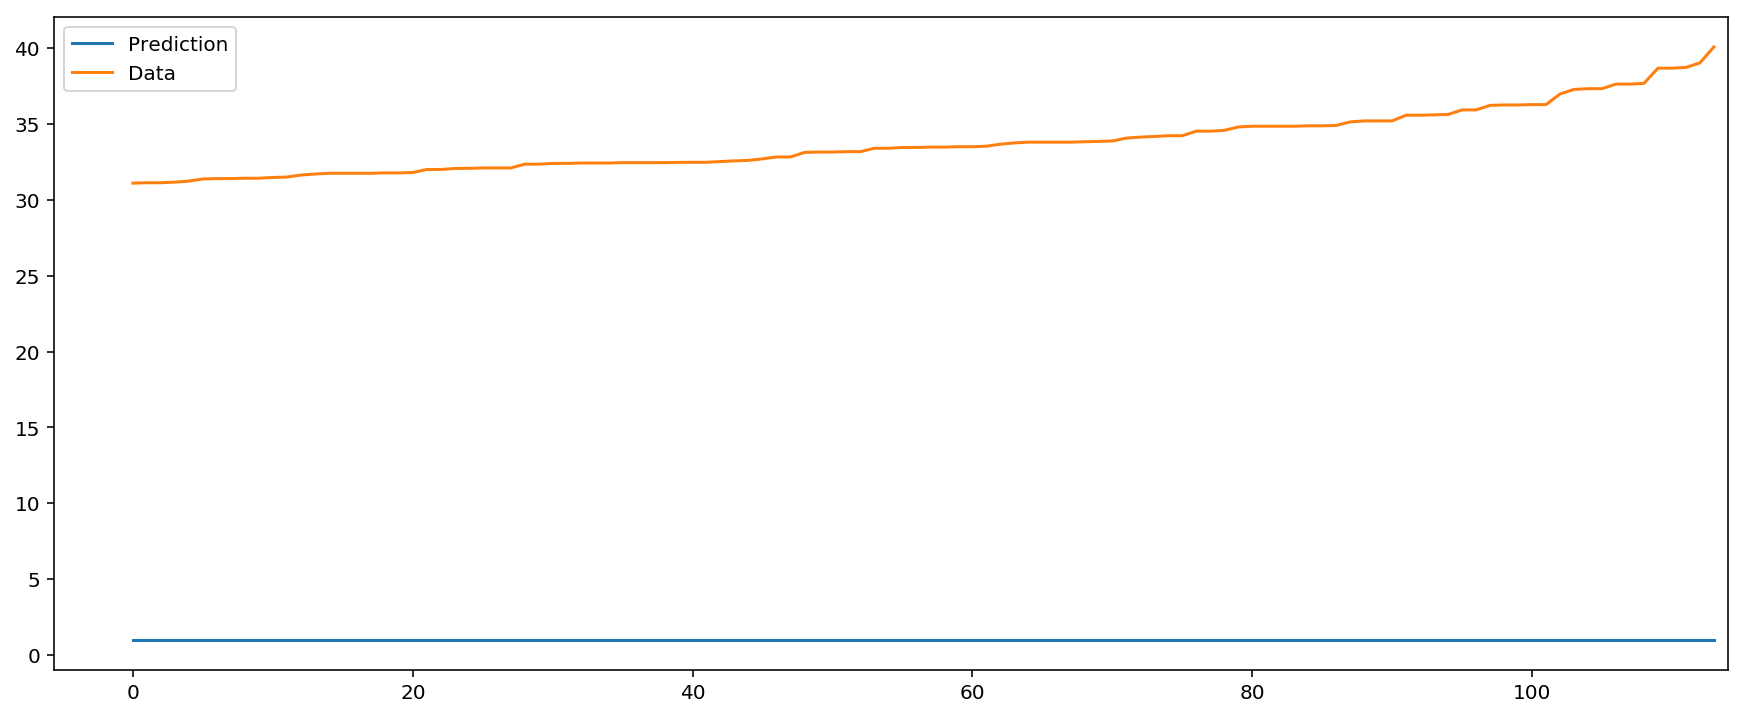

In [38]:
fig, ax = plt.subplots(figsize=(15,6))
predictions = model.predict(testX)
ax.plot(predictions,label='Prediction')
ax.plot(testY, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()